# I'm gonna use a dataset of patients who have anemia and healthy patients, the aim is to build a model that it accurately predicts anemia in affected individuals.
Dataset is available on  https://www.kaggle.com/datasets/zeesolver/uhygtttt

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from google.colab import drive
drive.mount('/content/drive') #I mounted my drive to have access to the dataset


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:

#Loading the dataset
df = pd.read_csv('/content/drive/MyDrive/anemia_dataset.csv')
df.drop('Number', axis = 1, inplace=True) #Removing the "number" column
df.isnull().sum() #Check for any null values
df

,Sex,%Red Pixel,%Green pixel,%Blue pixel,Hb,Anaemic
0,M,43.2555,30.8421,25.9025,6.3,Yes
1,F,45.6033,28.1900,26.2067,13.5,No
2,F,45.0107,28.9677,26.0215,11.7,No
3,F,44.5398,28.9899,26.4703,13.5,No
4,M,43.2870,30.6972,26.0158,12.4,No
...,...,...,...,...,...,...
99,F,49.9999,29.2860,20.7141,14.5,Yes
100,M,42.2324,30.6757,27.0919,6.3,Yes
101,F,45.6064,31.9084,22.4852,12.7,No
102,M,45.2095,29.2769,25.5136,13.4,No


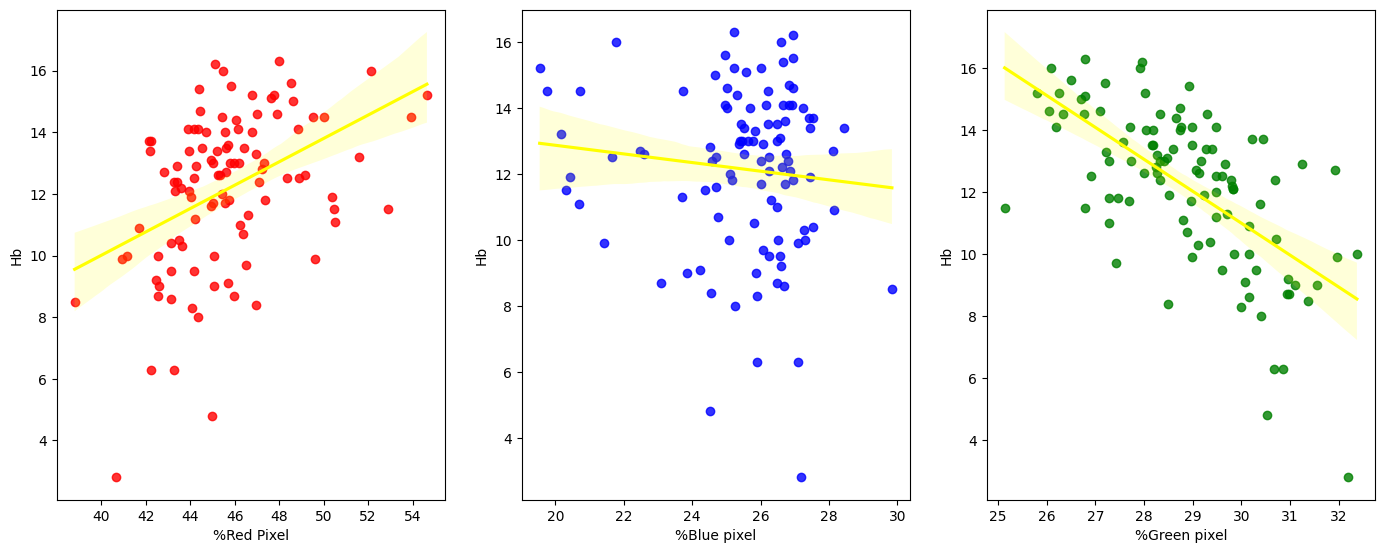

In [5]:
#Correlation analysis pixels vs hemoglobin levels

plt.figure(figsize = (17,14))
plt.subplot(2,3,1)
pixel_rossi_vs_hb = sns.regplot(data = df, x = '%Red Pixel', y = 'Hb', color = 'red', line_kws={'color':'yellow'})
plt.subplot(2,3,2)
pixel_blu_vs_hb = sns.regplot(data = df, x = '%Blue pixel', y = 'Hb', color = 'blue', line_kws={'color':'yellow'})
plt.subplot(2,3,3)
pixel_verde_vs_hb = sns.regplot(data = df, x = '%Green pixel', y = 'Hb', color = 'green', line_kws={'color':'yellow'})

plt.show()

There's likely a positive correlation between %red pixels and Hemoglobin levels, it's the opposite for green pixels and Hb.
I'll calculate Pearson coefficients to have more informations.
Pixels are referred to the digital images of blood samples, hemoglobin gives the tipical color of the red blood cells, hence I think that the intensity of red color described by percentual of pixels is proportional to Hb levels.



In [6]:
#P-values


pr = stats.pearsonr(df['%Red Pixel'], df['Hb'])
pg = stats.pearsonr(df['%Green pixel'], df['Hb'])
pb = stats.pearsonr(df['%Blue pixel'], df['Hb'])

print("Red =", round(pr.correlation,3))
print("Green =", round(pg.correlation,3))
print("Blue =", round(pb.correlation,3))

Red = 0.425
Green = -0.637
Blue = -0.103


# It's possible that there's an effective positive correlation between red pixels and Hb levels, negative for green pixels but there's a bad correlation for blue pixels.

To having a better accuracy from the predictive model I'll consider only red and green pixels


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

#Converting strings to  numbers (0,1) by LabelEncoder()
label_encoder = LabelEncoder()
df['Sex'] = label_encoder.fit_transform(df['Sex'])
df['Anaemic'] = label_encoder.fit_transform(df['Anaemic'])

# "Anemic" column has the outputs, so it's separated from the rest of the dataset
x = df.drop(columns = ['Anaemic'])
y = df['Anaemic'] #objective values

#X and Y are splitted into training and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)
''' Test_size = 0.2 means that the 20% of datas are used to test the model and the rest is used to train it.
Random_state ensures that the split is always the same every time that I run the code.'''

#Standardize x_train and x_teest
x_train = StandardScaler().fit_transform(x_train)
x_test = StandardScaler().fit_transform(x_test)

#Predictive model used is Random Forest
model = RandomForestClassifier()
model.fit(x_train, y_train) #Training the model

#Calculatint the predictions
y_pred = model.predict(x_test)

#Calculating the accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Model's accuracy is:", round(accuracy, 3))

#Showing the report
print(classification_report(y_test, y_pred))


Model's accuracy is: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       1.00      1.00      1.00         5

    accuracy                           1.00        21
   macro avg       1.00      1.00      1.00        21
weighted avg       1.00      1.00      1.00        21



# Accuracy metrics equals to 1 indicate that the  model didn't make false positives or false negatives

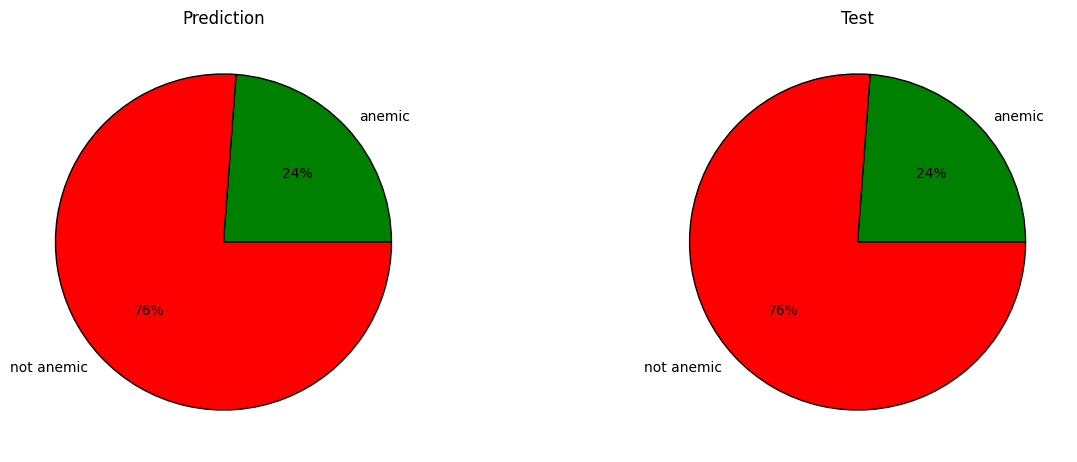

In [10]:
#I'll show the predicted values and the test values

pred = {"anemic":0, "not anemic":0}
test = {"anemic":0, "not anemic":0}

for a in y_pred:
  if a == 1:
    pred['anemic'] += 1
  else:
    pred["not anemic"] += 1

for b in y_test:
  if b == 1:
    test['anemic'] += 1
  else:
    test['not anemic'] += 1

plt.figure( figsize = (15, 12))
plt.subplot(2,2,1)
plt.pie(pred.values(), labels = pred.keys(), autopct = '%2.f%%', colors=  {'green','red'}, wedgeprops = {'edgecolor':'black'})
plt.title("Prediction")
plt.subplot(2,2,2)
plt.pie(test.values(), labels = test.keys(), autopct = '%2.f%%', colors=  {'green','red'}, wedgeprops = {'edgecolor':'black'})
plt.title("Test")
plt.show()

#The model accurately predicted the amount of anemic and non-anemic patients, one must consider that I used a small dataset but as a first approach to machine learning I think that it is a good start ✌
